## EDA 프로젝트 - 주식에 관한 여러 분석 - 거시적 관점.
#### 2024년 5월 7일 중간 정리 - 김나리

---

In [1]:
# 앞으로 쓰일 라이브러리들. 필요한 것을 한번에 설치하시고 진행하시면 좀더 편하게 보실 수 있습니다.
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import koreanize_matplotlib  
import FinanceDataReader as fdr
import requests
import pandas as pd
import numpy as np

#### 1. OECD 경기선행지수 와 수출동향 과의 관계 알아보기.
- 전년 동월 대비 수출 변화율과 OECD에서 발표한 한국 경기선행지수의 상관계수를 구하고 몇개월 선행인지 확인.


In [2]:
# OECD 경기 선행지수 불러오기.

df = pd.read_csv('./data/OECD_lead_indicator.csv',index_col=False)
df.rename(columns={'Unnamed: 0':'Date','한국':'Korea','미국':'USA','중국':'China'}, inplace=True) # 열의 이름을 영어로 바꾸기.

In [3]:
# OECD 경기선행지수 데이터 전처리.

df['Date'] = pd.to_datetime(df['Date'])
df.dropna(inplace=True)

In [4]:
# 수출입동향에 대한 파일 로딩 후 전년 동월 대비 변화율 계산

db_df = pd.read_csv("./data/ex_import.csv")
db_df['Date'] = pd.to_datetime(db_df['기간'])
db_df['YoY_ex'] = db_df['수출 금액'].pct_change(periods=12) * 100 # 수출에 관한 전년 동월 대비 변화율
db_df['YoY_im'] = db_df['수입 금액'].pct_change(periods=12) * 100 # 수입에 관한 전년 동월 대비 변화율

In [5]:
# 수출입동향 
db_df

,기간,조업일수,수출 금액,수입 금액,무역수지,Date,YoY_ex,YoY_im
0,2000-01,23.0,12162425,12594623,-432198,2000-01-01,NaN,NaN
1,2000-02,21.5,12676042,12023652,652390,2000-02-01,NaN,NaN
2,2000-03,24.0,14429703,14212011,217692,2000-03-01,NaN,NaN
3,2000-04,21.5,13522040,13344532,177508,2000-04-01,NaN,NaN
4,2000-05,22.0,14636755,13283356,1353399,2000-05-01,NaN,NaN
...,...,...,...,...,...,...,...,...
286,2023-11,24.0,55561090,51997805,3563285,2023-11-01,7.319102,-11.639971
287,2023-12,22.5,57573193,53122854,4450339,2023-12-01,4.967353,-10.902171
288,2024-01,24.0,54771268,54357416,413853,2024-01-01,18.196544,-7.926931
289,2024-02,20.5,52423042,48084919,4338122,2024-02-01,4.857423,-13.157872


In [6]:
# OECD 경기 선행지수
df

,Date,G20,Korea,USA,China
448,1992-05-01,99.34471,97.22546,99.65401,100.5691
449,1992-06-01,99.29321,97.26673,99.68332,100.8778
450,1992-07-01,99.19867,97.31989,99.67242,101.1525
451,1992-08-01,99.09048,97.39674,99.66218,101.3872
452,1992-09-01,99.00390,97.50542,99.69567,101.5828
...,...,...,...,...,...
826,2023-11-01,99.99977,100.08220,99.44604,100.9406
827,2023-12-01,100.10340,100.30840,99.55394,101.0964
828,2024-01-01,100.22550,100.51900,99.69483,101.2657
829,2024-02-01,100.36140,100.71640,99.85309,101.4638


In [7]:
# "Date"열을 기준으로 두 파일 합치기
test = pd.merge(db_df,df,on='Date',how='inner')[['Korea','YoY_ex','Date']]
test.set_index("Date", inplace=True)
test

,Korea,YoY_ex
Date,,
2000-01-01,104.3870,NaN
2000-02-01,103.9028,NaN
2000-03-01,103.4638,NaN
2000-04-01,103.0930,NaN
2000-05-01,102.7531,NaN
...,...,...
2023-11-01,100.0822,7.319102
2023-12-01,100.3084,4.967353
2024-01-01,100.5190,18.196544


In [8]:
import numpy as np
test = test.dropna()
# g_list = np.array(df['G20'].rolling(window=2).mean().values)
k_list = np.array(test['Korea'].values) # 한국 경기 선행지수를 np array로 설정.

for i in range(1,10):
    j=3
    month = 120 # 2024년 3월을 기준으로 10년 전의 값에서 부터 상관관계를 구함.
    g_list = np.array(test['YoY_ex'].ewm(span=j, adjust=False).mean().values) # 전년동월 수출변화량의 j개월 이동평균선. EMA( Exponential Month Average ) 사용.
    print(i,"개월 선행: 상관계수",np.corrcoef(g_list[-month+i:], k_list[-month:-i])[0, 1]) # 경기선행지수와 수출 변화율 상관계수 구하기. (i 값만큼 한국 경기선행지수가 선행적으로 움직일때)

1 개월 선행: 상관계수 0.7612292552957499
2 개월 선행: 상관계수 0.8014541863734159
3 개월 선행: 상관계수 0.819097311263714
4 개월 선행: 상관계수 0.8161331357661206
5 개월 선행: 상관계수 0.7939419631670243
6 개월 선행: 상관계수 0.7566046389679334
7 개월 선행: 상관계수 0.704953827119728
8 개월 선행: 상관계수 0.6406186198652754
9 개월 선행: 상관계수 0.5678329428836465


- 위에서 보듯이 3개월일 때의 값이 가장 크다.
- 3개월 ~ 4개월 선행하는 지수라고 분석할수 있겠다.

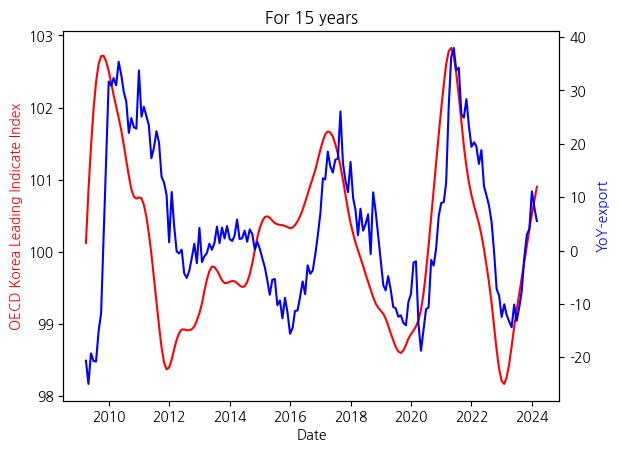

In [9]:
import matplotlib.pyplot as plt

# 첫 번째 그래프 그리기
fig, ax1 = plt.subplots()

# month개월 전부터 현재까지의 데이터를 그립니다.
month = 180

ax1.plot(test.index[-month:],test['Korea'].values[-month:], color='red')

# 두 번째 축 생성
ax2 = ax1.twinx()

# 전년동월 수출변화량의 3개월 이동평균선. EMA( Exponential Month Average ) 사용. 
ax2.plot(test.index[-month:], test['YoY_ex'].ewm(span=3, adjust=False).mean().values[-month:], color='blue')

# 각 축의 라벨 설정
ax1.set_xlabel('Date')
ax1.set_ylabel('OECD Korea Leading Indicate Index', color='r')
ax2.set_ylabel('YoY-export', color='b')
plt.title(f"For {int(month/12)} years")
plt.show()

- 두 그래프를 매치시켜보자!!

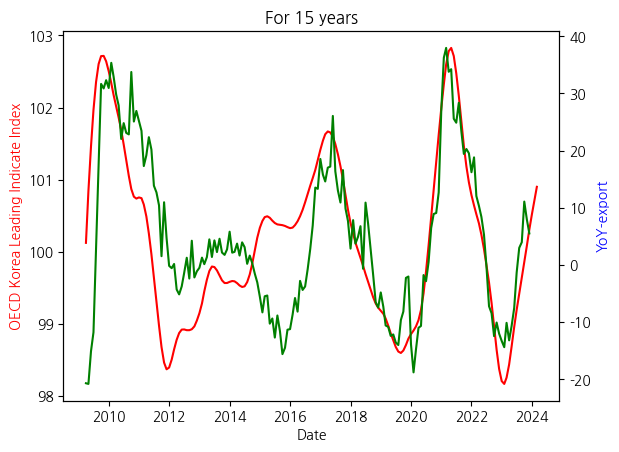

In [10]:
## 그래프 매치시키기
# 첫 번째 그래프 그리기
fig, ax1 = plt.subplots()

# month개월 전부터 현재까지의 데이터를 그립니다.
month = 180

ax1.plot(test.index[-month:],test['Korea'].values[-month:], color='red')

# 두 번째 축 생성
ax2 = ax1.twinx()

# 전년동월 수출변화량의 3개월 이동평균선. EMA( Exponential Month Average ) 사용. 
# ax2.plot(test.index[-month:], test['YoY_ex'].ewm(span=3, adjust=False).mean().values[-month:], color='blue')
i = 3
ax2.plot(test.index[-month:-i], test['YoY_ex'].ewm(span=3, adjust=False).mean().values[-month+i:], color='green')

# 각 축의 라벨 설정
ax1.set_xlabel('Date')
ax1.set_ylabel('OECD Korea Leading Indicate Index', color='r')
ax2.set_ylabel('YoY-export', color='b')
plt.title(f"For {int(month/12)} years")
plt.show()

## 그래프 아래의 설명 참고.

- 경기선행지수가 3개월 선행한다고 해서 위와 같이 그래프를 그려봄.
- 초록색 그래프가 3개월 당겨서 그린 그래프임.

---

#### 2. 수출동향과 코스피와의 관계

- 일평균수출량과 코스피의 관계
- 일평균 수출금액 = 월별 수출금액 / 조업일수

In [11]:
# 일평균 수출금액 = 월별 수출금액 / 조업일수
db_df["ave_day_ex"]=db_df["수출 금액"]/db_df["조업일수"]
db_df

,기간,조업일수,수출 금액,수입 금액,무역수지,Date,YoY_ex,YoY_im,ave_day_ex
0,2000-01,23.0,12162425,12594623,-432198,2000-01-01,NaN,NaN,5.288011e+05
1,2000-02,21.5,12676042,12023652,652390,2000-02-01,NaN,NaN,5.895833e+05
2,2000-03,24.0,14429703,14212011,217692,2000-03-01,NaN,NaN,6.012376e+05
3,2000-04,21.5,13522040,13344532,177508,2000-04-01,NaN,NaN,6.289321e+05
4,2000-05,22.0,14636755,13283356,1353399,2000-05-01,NaN,NaN,6.653070e+05
...,...,...,...,...,...,...,...,...,...
286,2023-11,24.0,55561090,51997805,3563285,2023-11-01,7.319102,-11.639971,2.315045e+06
287,2023-12,22.5,57573193,53122854,4450339,2023-12-01,4.967353,-10.902171,2.558809e+06
288,2024-01,24.0,54771268,54357416,413853,2024-01-01,18.196544,-7.926931,2.282136e+06
289,2024-02,20.5,52423042,48084919,4338122,2024-02-01,4.857423,-13.157872,2.557222e+06


In [12]:
temp = db_df[['Date','ave_day_ex']]
temp.loc[:,'Date'] = temp.loc[:,'Date']- timedelta(days=1)
temp

,Date,ave_day_ex
0,1999-12-31,5.288011e+05
1,2000-01-31,5.895833e+05
2,2000-02-29,6.012376e+05
3,2000-03-31,6.289321e+05
4,2000-04-30,6.653070e+05
...,...,...
286,2023-10-31,2.315045e+06
287,2023-11-30,2.558809e+06
288,2023-12-31,2.282136e+06
289,2024-01-31,2.557222e+06


In [13]:
# 코스피 지수 불러오기. 아래의 라이브러리 사용.
import FinanceDataReader as fdr

df = fdr.DataReader('KS11','2000-01-01','2024-05-05')
kospi = df[["Close"]]

In [14]:

from datetime import datetime, timedelta

temp = temp.dropna()
kospi_ex = temp.set_index("Date").join(kospi)[["ave_day_ex","Close"]]
nan_date = kospi_ex.loc[kospi_ex["Close"].isna()].index
for date in nan_date:
    n_date = date
    while True:
        n_date = n_date+ timedelta(days=1)
        if n_date in kospi.index:
            kospi_ex.loc[date,"Close"]=kospi.loc[n_date,"Close"]
            break

kospi_ex

,ave_day_ex,Close
Date,,
1999-12-31,5.288011e+05,1059.04
2000-01-31,5.895833e+05,943.88
2000-02-29,6.012376e+05,828.38
2000-03-31,6.289321e+05,860.94
2000-04-30,6.653070e+05,752.59
...,...,...
2023-10-31,2.315045e+06,2277.99
2023-11-30,2.558809e+06,2535.29
2023-12-31,2.282136e+06,2669.81


In [15]:
kospi_ex.rename({"Close":"KOSPI"},axis=1,inplace=True)
kospi_ex

,ave_day_ex,KOSPI
Date,,
1999-12-31,5.288011e+05,1059.04
2000-01-31,5.895833e+05,943.88
2000-02-29,6.012376e+05,828.38
2000-03-31,6.289321e+05,860.94
2000-04-30,6.653070e+05,752.59
...,...,...
2023-10-31,2.315045e+06,2277.99
2023-11-30,2.558809e+06,2535.29
2023-12-31,2.282136e+06,2669.81


<Axes: xlabel='Date'>

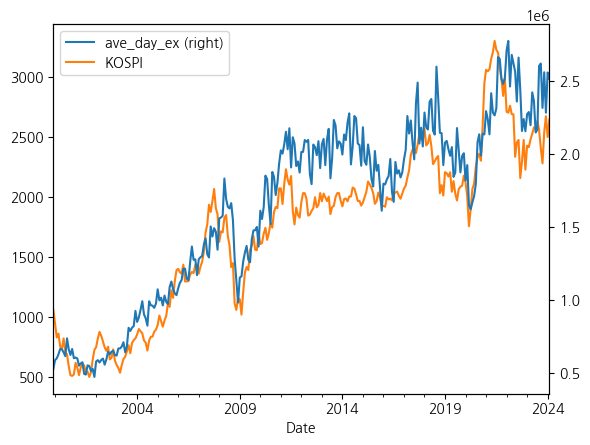

In [16]:
kospi_ex.plot(secondary_y="ave_day_ex")

In [17]:
import numpy as np

kospi_np = np.array(kospi_ex.loc[pd.to_datetime("2005-04-30"):,'KOSPI'])
ave_ex = np.array(kospi_ex.loc[pd.to_datetime("2005-04-30"):,'ave_day_ex'])

print(np.corrcoef(kospi_np,ave_ex)[0, 1])

for i in range(1,10):
    print(i,'개월 선행 상관계수',np.corrcoef(kospi_np[:-i],ave_ex[i:])[0, 1])
    

0.8638510613450607
1 개월 선행 상관계수 0.8761671621604136
2 개월 선행 상관계수 0.8771959200473275
3 개월 선행 상관계수 0.8723624078694469
4 개월 선행 상관계수 0.8749060916910242
5 개월 선행 상관계수 0.8683887449384868
6 개월 선행 상관계수 0.8620870378705339
7 개월 선행 상관계수 0.8507051270162937
8 개월 선행 상관계수 0.8442317827855516
9 개월 선행 상관계수 0.8275542334909866


- 위의 결과로 보면 코스피지수가 일평균 수출액에 2개월 선행한다고 볼수 있다.
- 코스피 지수가 선행이기 때문에 일평균 수출액을 회귀분석하여 코스피지수의 방향성을 예측할 수 있다.

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 독립변수와 종속변수 설정
X = kospi_ex.loc[pd.to_datetime("2015-01-31"):,'ave_day_ex']  # 일평균 수출액
y = kospi_ex.loc[pd.to_datetime("2015-01-31"):,'KOSPI']  # 코스피지수

# 상수항 추가
X = sm.add_constant(X)

# 회귀분석 모델 학습
model = sm.OLS(y, X)
result = model.fit()

# 회귀분석 결과 출력
print(result.summary())

# 예측값 계산
predicted = result.predict(X)

# 잔차 계산
residuals = (y - predicted) / y * 100


                            OLS Regression Results                            
Dep. Variable:                  KOSPI   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     100.7
Date:                Tue, 07 May 2024   Prob (F-statistic):           3.85e-17
Time:                        16:46:32   Log-Likelihood:                -765.22
No. Observations:                 110   AIC:                             1534.
Df Residuals:                     108   BIC:                             1540.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.5332    190.056      2.392      0.0

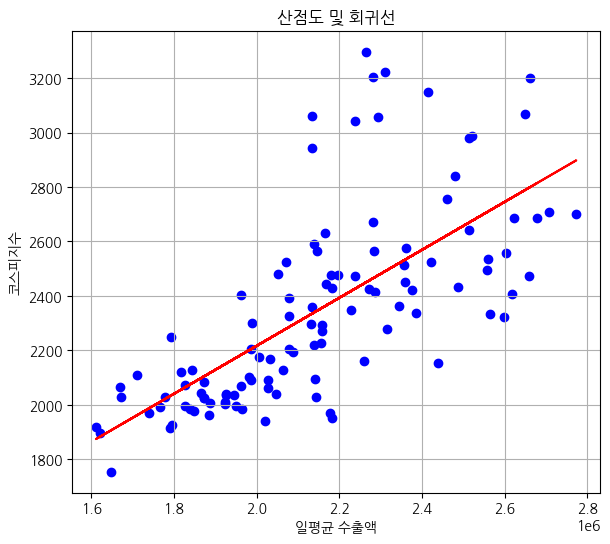

In [19]:
# 산점도 그래프 그리기
plt.figure(figsize=(15, 6))

# 산점도 그리기
plt.subplot(1, 2, 1)
plt.scatter(X.iloc[:, 1], y, color='blue')
plt.plot(X.iloc[:, 1], predicted, color='red')  # 회귀선 추가
plt.xlabel('일평균 수출액')
plt.ylabel('코스피지수')
plt.title('산점도 및 회귀선')
plt.grid(True)

<Figure size 1000x500 with 0 Axes>

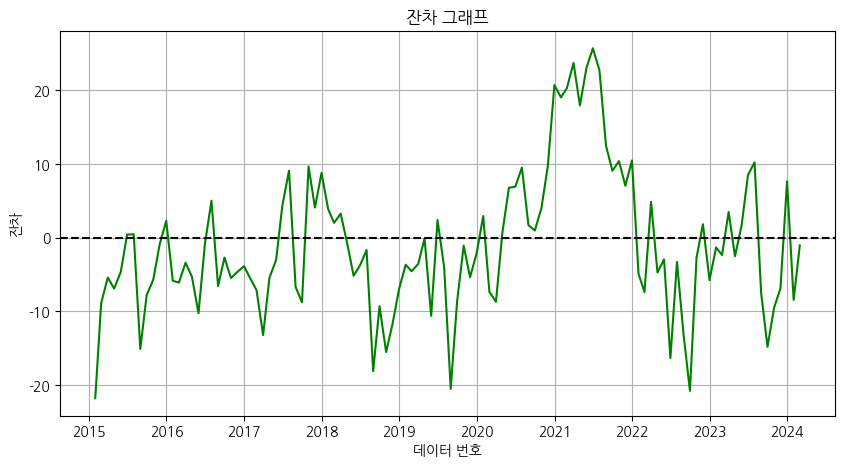

In [20]:
import matplotlib.pyplot as plt
import koreanize_matplotlib  

plt.figure(figsize=(10, 5))

# 잔차 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(residuals, color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('데이터 번호')
plt.ylabel('잔차')
plt.title('잔차 그래프')
plt.grid(True)
plt.show()


- 0 값을 중심으로 잔차가 왔다갔다 하는 것을 볼수 있다.
- 확실한 것은 모르지만 2021년 ~ 2022년와 2018년~ 2019년 사이를 제외하고는 0값을 3번은 지나간다.
- 그러므로 예상되는 값의 아래에서 코스피 지수를 따르는 주식을 샀다면, 1년에 적어도 한번은 적금이율보다 높은 수익율(약 10프로 정도)을 얻을 기회가 있다는 것이다.
- 위의 경우는 단타 거래의 경우에 대한 얘기이고, 전체적으로 코스피지수는 계속 우상향 하고 있긴하다.

#### 3. 수출동향과 코스닥과의 관계

- 코스피와 동일해서 빠르게 그래프 그리고 넘어가겠다.

<Axes: xlabel='Date'>

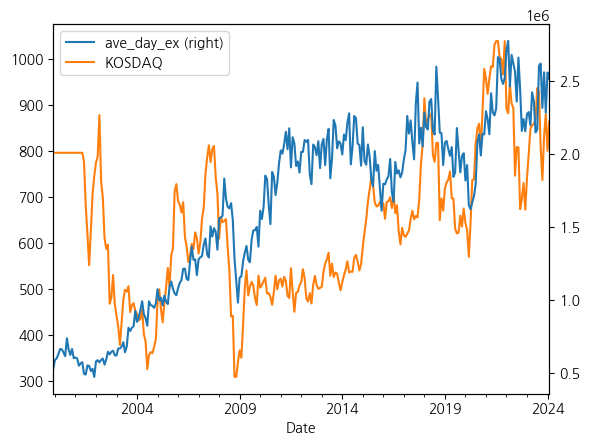

In [21]:
# 코스닥 지수 불러오기. 아래의 라이브러리 사용.

df = fdr.DataReader('KQ11')
kosdaq = df[["Close"]]

temp = temp.dropna()
kosdaq_ex = temp.set_index("Date").join(kosdaq)[["ave_day_ex","Close"]]
nan_date = kosdaq_ex.loc[kosdaq_ex["Close"].isna()].index
for date in nan_date:
    n_date = date
    while True:
        n_date = n_date+ timedelta(days=1)
        if n_date in kosdaq.index:
            kosdaq_ex.loc[date,"Close"]=kosdaq.loc[n_date,"Close"]
            break
kosdaq_ex.rename({"Close":"KOSDAQ"},axis=1,inplace=True)
kosdaq_ex.plot(secondary_y="ave_day_ex")

In [22]:
import numpy as np

kosdaq_np = np.array(kosdaq_ex.loc[pd.to_datetime("2004-03-31"):,'KOSDAQ'])
ave_ex = np.array(kosdaq_ex.loc[pd.to_datetime("2004-03-31"):,'ave_day_ex'])

print(np.corrcoef(kosdaq_np,ave_ex)[0, 1])

print("\n20년간 일평균 수출액과 코스닥과의 상관계수\n")
for i in range(1,10):
    print(i,'개월 선행 상관계수',np.corrcoef(kosdaq_np[:-i],ave_ex[i:])[0, 1])
    

0.591430197383725

20년간 일평균 수출액과 코스닥과의 상관계수

1 개월 선행 상관계수 0.6048952797076713
2 개월 선행 상관계수 0.6070929613336709
3 개월 선행 상관계수 0.6040536339536425
4 개월 선행 상관계수 0.6061104017458673
5 개월 선행 상관계수 0.6019317715650891
6 개월 선행 상관계수 0.5931827694372771
7 개월 선행 상관계수 0.5786324905089802
8 개월 선행 상관계수 0.5743156935154446
9 개월 선행 상관계수 0.5576287856417703


- 20년간의 데이터에서 보면, 코스닥 지수가 2 개월 정도 선행한다고 볼수 있으나, 상관계수 값이 작음.
- 위에 그래프에서 볼때 2000년 초반에서 2014년 까지 그래프의 모양이 전혀 다른 양상임을 알수 있음.
- 최근 10년간이 꽤 비슷한 양상으로 가고 있다고 판단됨.

In [23]:
import numpy as np

kosdaq_np = np.array(kosdaq_ex.loc[pd.to_datetime("2014-03-31"):,'KOSDAQ'])
ave_ex = np.array(kosdaq_ex.loc[pd.to_datetime("2014-03-31"):,'ave_day_ex'])

print(np.corrcoef(kosdaq_np,ave_ex)[0, 1])

print("\n10년간 일평균 수출액과 코스닥과의 상관계수\n")
for i in range(1,10):
    print(i,'개월 선행 상관계수',np.corrcoef(kosdaq_np[:-i],ave_ex[i:])[0, 1])
    

0.5695604524403409

10년간 일평균 수출액과 코스닥과의 상관계수

1 개월 선행 상관계수 0.6180614398754208
2 개월 선행 상관계수 0.6371338472703509
3 개월 선행 상관계수 0.6551780970502992
4 개월 선행 상관계수 0.6667936020669456
5 개월 선행 상관계수 0.6681340518230605
6 개월 선행 상관계수 0.6689556343402646
7 개월 선행 상관계수 0.6511593472534963
8 개월 선행 상관계수 0.6508993219384561
9 개월 선행 상관계수 0.6109128530666179


- 10년간의 데이터에서 보면, 상관계수값이 좀 더 높아지긴 했으나 몇개월 선행지수인지 알아내기가 애매함.
- 상관계수값으로만 따지면 6개월이라고 할 수 있음.

In [24]:
kosdaq_ex

,ave_day_ex,KOSDAQ
Date,,
1999-12-31,5.288011e+05,795.20
2000-01-31,5.895833e+05,795.20
2000-02-29,6.012376e+05,795.20
2000-03-31,6.289321e+05,795.20
2000-04-30,6.653070e+05,795.20
...,...,...
2023-10-31,2.315045e+06,736.10
2023-11-30,2.558809e+06,831.68
2023-12-31,2.282136e+06,878.93


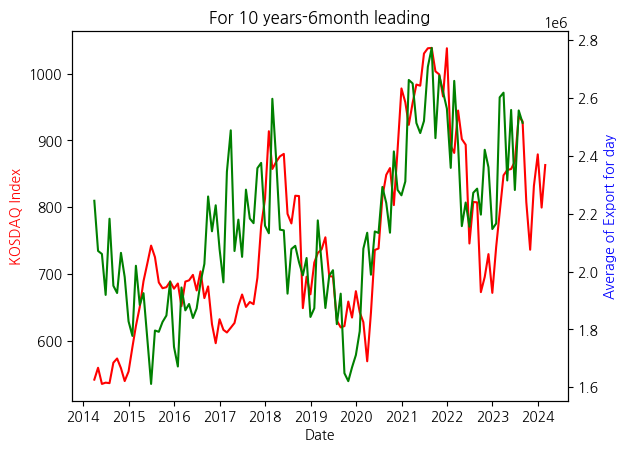

In [25]:
## 그래프 매치시키기
# 첫 번째 그래프 그리기
fig, ax1 = plt.subplots()

# month개월 전부터 현재까지의 데이터를 그립니다.
month = 120

ax1.plot(kosdaq_ex.index[-month:],kosdaq_ex['KOSDAQ'].values[-month:], color='red')

# 두 번째 축 생성
ax2 = ax1.twinx()

# 전년동월 수출변화량의 3개월 이동평균선. EMA( Exponential Month Average ) 사용. 
# ax2.plot(test.index[-month:], test['YoY_ex'].ewm(span=3, adjust=False).mean().values[-month:], color='blue')
i = 6
ax2.plot(kosdaq_ex.index[-month:-i], kosdaq_ex['ave_day_ex'].values[-month+i:], color='green')

# 각 축의 라벨 설정
ax1.set_xlabel('Date')
ax1.set_ylabel('KOSDAQ Index', color='r')
ax2.set_ylabel('Average of Export for day', color='b')
plt.title(f"For {int(month/12)} years-{i}month leading")
plt.show()

## 그래프 아래의 설명 참고.

- 위에는 코스닥지수 6개월 선행값과 일평균 수출액을 매치시킨 그래프.
- 위의 코드에서 i 값을 변경하면 원하는 개월의 선행그래프와 매치시킬 수 있다.

- 코스피 코스닥지수 둘다 일평균수출액보다 선행하여 움직이는 그래프다.
- 그럼 여기서 드는 의문은 그럼 이걸 어떻게 써야하나? 인데..
- 경기선행지수가 3 ~ 4개월 선행함 -> 3~4개월 후의 일평균 수출액 예측 가능
- 코스피가 2개월 선행함 -> 여기서는 의미가 있을 수도 있겠으나,
- 코스닥이 6개월 선행함 -> 여기서는 의미를 찾을 수 있을까?

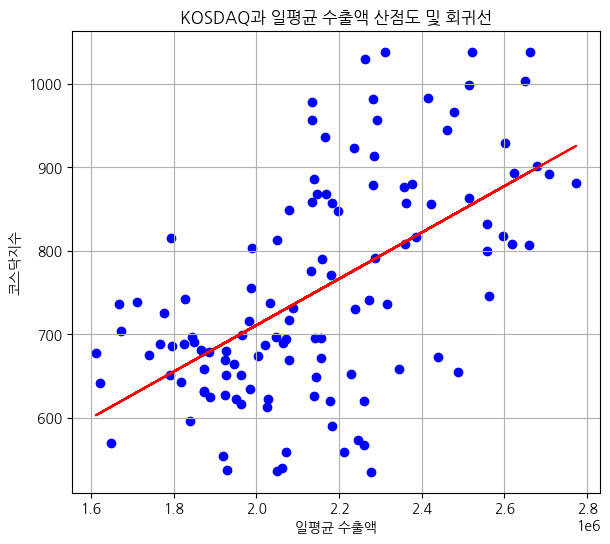

<Figure size 1000x500 with 0 Axes>

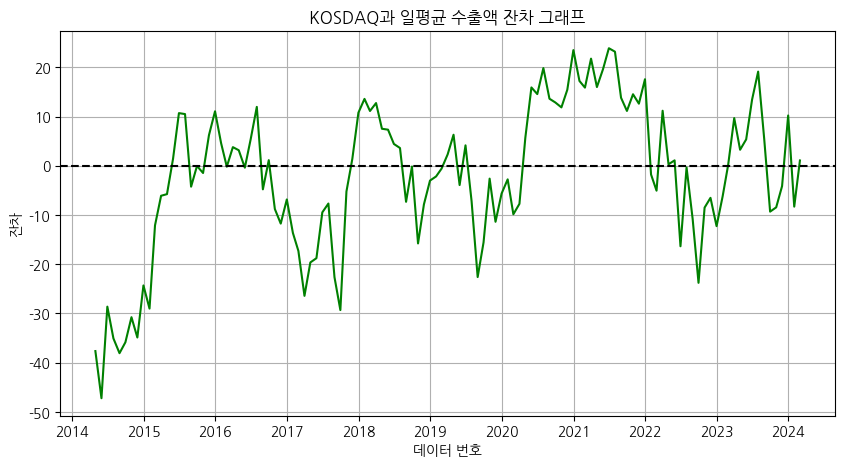

Date
2014-04-30   -37.634327
2014-05-31   -47.211278
2014-06-30   -28.611813
2014-07-31   -35.063129
2014-08-31   -38.063803
                ...    
2023-10-31    -8.440740
2023-11-30    -4.123491
2023-12-31    10.221885
2024-01-31    -8.294532
2024-02-29     1.083896
Length: 119, dtype: float64

In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import koreanize_matplotlib  

# 독립변수와 종속변수 설정
X = kosdaq_ex.loc[pd.to_datetime("2014-04-30"):,'ave_day_ex']  # 일평균 수출액
y = kosdaq_ex.loc[pd.to_datetime("2014-04-30"):,'KOSDAQ']  # 코스피지수

# 상수항 추가
X = sm.add_constant(X)

# 회귀분석 모델 학습
model = sm.OLS(y, X)
result = model.fit()

# 회귀분석 결과 출력
# print(result.summary())

# 예측값 계산
predicted = result.predict(X)

# 잔차 계산
residuals = (y - predicted) / y * 100

# 산점도 그래프 그리기
plt.figure(figsize=(15, 6))

# 산점도 그리기
plt.subplot(1, 2, 1)
plt.scatter(X.iloc[:, 1], y, color='blue')
plt.plot(X.iloc[:, 1], predicted, color='red')  # 회귀선 추가
plt.xlabel('일평균 수출액')
plt.ylabel('코스닥지수')
plt.title('KOSDAQ과 일평균 수출액 산점도 및 회귀선')
plt.grid(True)

# 그래프 그리기
plt.figure(figsize=(10, 5))

# 잔차 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(residuals, color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('데이터 번호')
plt.ylabel('잔차')
plt.title('KOSDAQ과 일평균 수출액 잔차 그래프')
plt.grid(True)
plt.show()

residuals


- 코스닥지수를 잘 따르는 종목들에 한하여 위와 같은 그래프들을 활용하여 값을 예측해볼 수 있겠으나
- 확실히 수출입 동향과 맞는 건 코스피 지수인듯.

---

#### 4. 명목GDP과 코스피와의 관계 

In [38]:
import datetime                     
import requests
import pandas as pd
from pathlib import Path
from bs4 import BeautifulSoup

private_api_key = "O93NS87HSQXXEP50NV7L"

# ECOS 에서 데이터를 호출하는 함수를 만듭니다.
def EcosDownload(Statcode, Freq, Begdate, Enddate, Subcode1, Subcode2, Subcode3):
    url = 'http://ecos.bok.or.kr/api/StatisticSearch/%s/xml/kr/1/100000/%s/%s/%s/%s/%s/%s/%s/'%(private_api_key, Statcode, Freq, Begdate, Enddate, Subcode1, Subcode2, Subcode3)
    raw = requests.get(url)
    xml = BeautifulSoup(raw.text,"xml")

    # Pandas 데이터프레임으로 전환합니다.
    raw_data = xml.find_all("row")
    date_list = []
    value_list = []

    for item in raw_data:
        value = item.find('DATA_VALUE').text.encode('utf-8')
        date_str = item.find('TIME').text
        value = float(value)
        date_list.append(datetime.datetime.strptime(date_str,'%Y'))
        value_list.append(value)

    df = pd.DataFrame(index = date_list)
    df['value'] = value_list

    return df


/var/folders/dx/nbps4v_56fn56_y2bh74p3q80000gn/T/ipykernel_62048/3039680608.py:2: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  GDP_raw.index = GDP_raw.index + pd.DateOffset(years=1) - pd.DateOffset(day=1, month=1) - timedelta(days=1)


<Axes: >

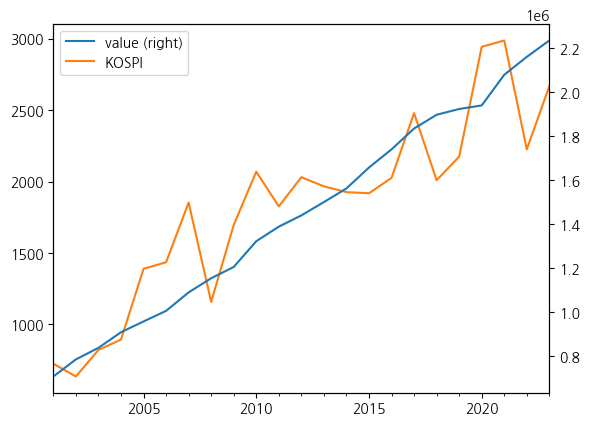

In [49]:
GDP_raw = EcosDownload('200Y001', 'A', '2001', '2024', '10101','','') 
GDP_raw.index = GDP_raw.index + pd.DateOffset(years=1) - pd.DateOffset(day=1, month=1) - timedelta(days=1)
GDP = GDP_raw.join(kospi_ex[["KOSPI"]])
GDP.plot(secondary_y="value")

                            OLS Regression Results                            
Dep. Variable:                  KOSPI   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     87.34
Date:                Tue, 07 May 2024   Prob (F-statistic):           6.25e-09
Time:                        17:03:07   Log-Likelihood:                -162.54
No. Observations:                  23   AIC:                             329.1
Df Residuals:                      21   BIC:                             331.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6947    204.447     -0.003      0.9

<Figure size 1000x500 with 0 Axes>

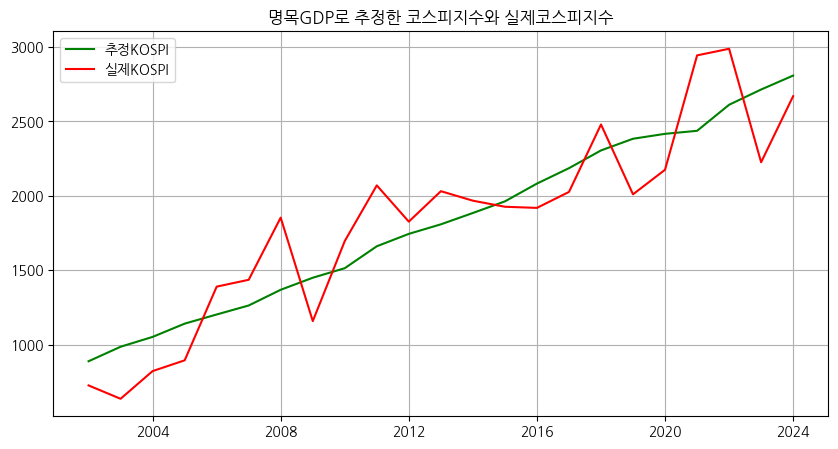

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


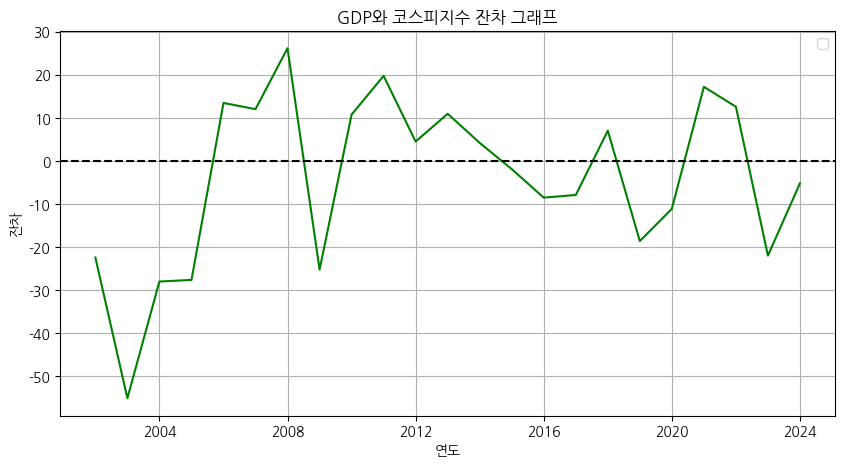

2001-12-31   -22.413553
2002-12-31   -55.086952
2003-12-31   -27.994736
2004-12-31   -27.608521
2005-12-31    13.478824
2006-12-31    12.036740
2007-12-31    26.186698
2008-12-31   -25.210443
2009-12-31    10.773012
2010-12-31    19.775259
2011-12-31     4.508267
2012-12-31    10.968670
2013-12-31     4.199700
2014-12-31    -1.876713
2015-12-31    -8.509864
2016-12-31    -7.888944
2017-12-31     7.033833
2018-12-31   -18.593956
2019-12-31   -11.107749
2020-12-31    17.228429
2021-12-31    12.593910
2022-12-31   -21.978494
2023-12-31    -5.194465
dtype: float64

In [46]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import koreanize_matplotlib  

# 독립변수와 종속변수 설정
X = GDP["value"]  # 일평균 수출액
y = GDP["KOSPI"]  # 코스피지수

# 상수항 추가
X = sm.add_constant(X)

# 회귀분석 모델 학습
model = sm.OLS(y, X)
result = model.fit()

# 회귀분석 결과 출력
print(result.summary())

# 예측값 계산
predicted = result.predict(X)

# 잔차 계산
residuals = (y - predicted) / y * 100

# 그래프 그리기
plt.figure(figsize=(10, 5))

# 잔차 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(predicted, color='green', label="추정KOSPI")
plt.plot(y, color='red',label="실제KOSPI")
plt.title("명목GDP로 추정한 코스피지수와 실제코스피지수")
plt.legend()
plt.grid(True)
plt.show()

# 잔차 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(residuals, color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('연도')
plt.ylabel('잔차')
plt.title('GDP와 코스피지수 잔차 그래프')
plt.legend()
plt.grid(True)
plt.show()

residuals


<Axes: >

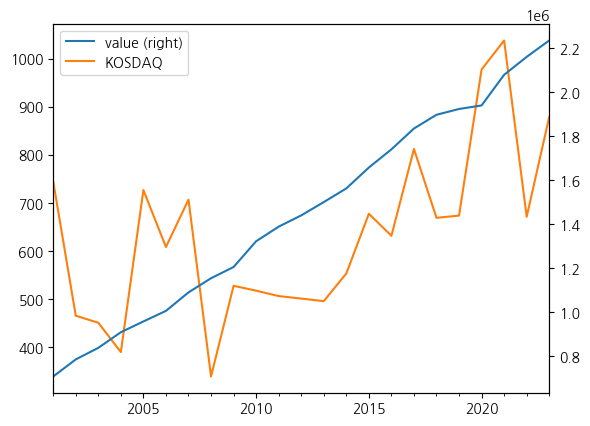

In [53]:
GDP_daq = GDP_raw.join(kosdaq_ex[["KOSDAQ"]])
GDP_daq.plot(secondary_y="value")

<Axes: >

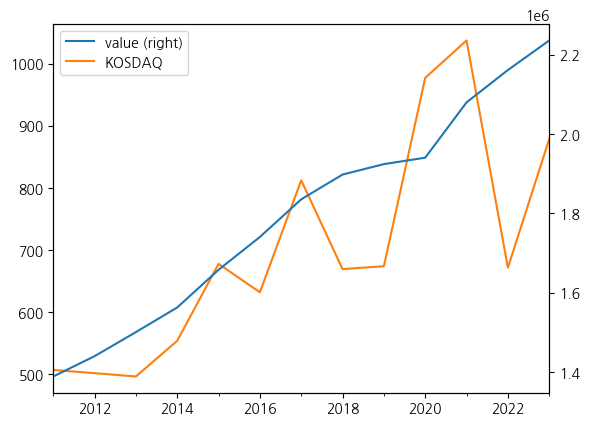

In [54]:
GDP_daq[10:].plot(secondary_y="value")

                            OLS Regression Results                            
Dep. Variable:                 KOSDAQ   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     11.19
Date:                Tue, 07 May 2024   Prob (F-statistic):            0.00307
Time:                        17:07:37   Log-Likelihood:                -146.40
No. Observations:                  23   AIC:                             296.8
Df Residuals:                      21   BIC:                             299.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        310.5202    101.335      3.064      0.0

<Figure size 1000x500 with 0 Axes>

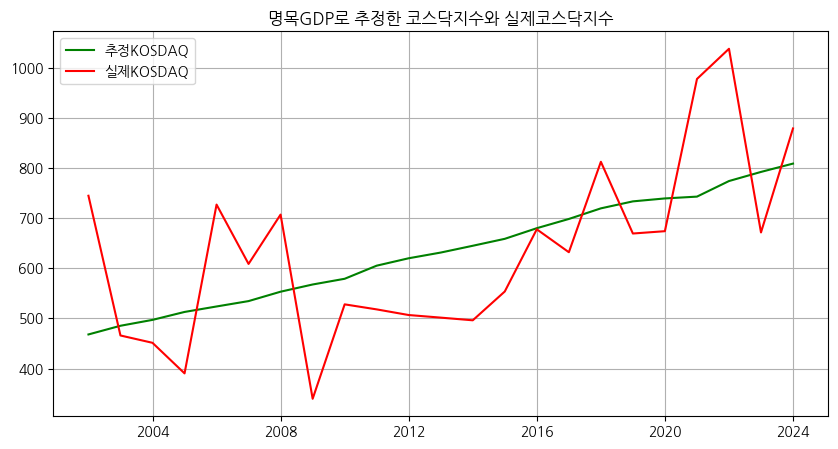

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


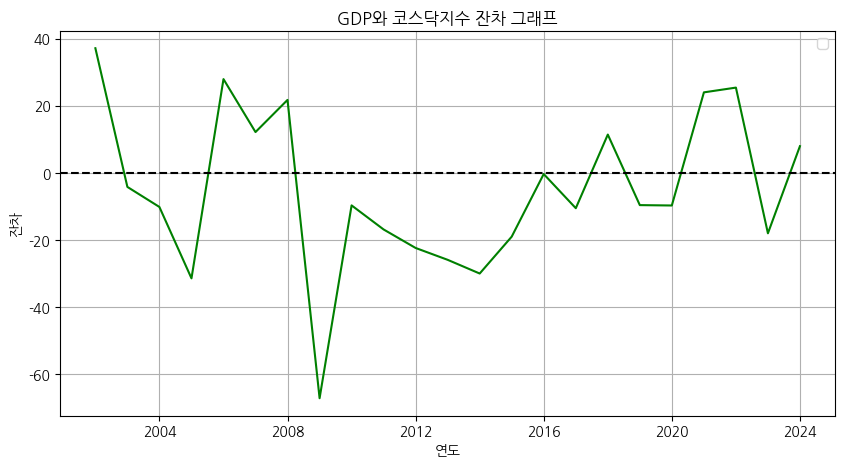

2001-12-31    37.147537
2002-12-31    -4.158854
2003-12-31   -10.125419
2004-12-31   -31.389154
2005-12-31    27.948670
2006-12-31    12.177445
2007-12-31    21.749654
2008-12-31   -67.091067
2009-12-31    -9.659703
2010-12-31   -16.828718
2011-12-31   -22.340668
2012-12-31   -25.877309
2013-12-31   -29.954939
2014-12-31   -18.971338
2015-12-31    -0.321451
2016-12-31   -10.500853
2017-12-31    11.433339
2018-12-31    -9.578434
2019-12-31    -9.692099
2020-12-31    24.002914
2021-12-31    25.417395
2022-12-31   -17.975561
2023-12-31     7.975547
dtype: float64

In [56]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import koreanize_matplotlib  

# 독립변수와 종속변수 설정
X = GDP_daq["value"]  # 일평균 수출액
y = GDP_daq["KOSDAQ"]  # 코스피지수

# 상수항 추가
X = sm.add_constant(X)

# 회귀분석 모델 학습
model = sm.OLS(y, X)
result = model.fit()

# 회귀분석 결과 출력
print(result.summary())

# 예측값 계산
predicted = result.predict(X)

# 잔차 계산
residuals = (y - predicted) / y * 100

# 그래프 그리기
plt.figure(figsize=(10, 5))

# 잔차 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(predicted, color='green', label="추정KOSDAQ")
plt.plot(y, color='red',label="실제KOSDAQ")
plt.title("명목GDP로 추정한 코스닥지수와 실제코스닥지수")
plt.legend()
plt.grid(True)
plt.show()

# 잔차 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(residuals, color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('연도')
plt.ylabel('잔차')
plt.title('GDP와 코스닥지수 잔차 그래프')
plt.legend()
plt.grid(True)
plt.show()

residuals


- 위의 값을 보면 2023-12-31에 7.97인데 이 값은 잔차값으로써 실제 코스닥지수가 추정 코스닥지수보다 약 8프로 정도 높다는 것이다.
- 수출입 동향을 봤을때 아직은 올라갈 여력이 남았지만, 이미 많이 높아진 코스닥 지수이므로 조만간 조정이 있을 것이라 추정된다.